In [1]:
__author__ = "Philipp Kats"
__date__ = "2016_04_23"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gp

import pylab as plt
import os

from sklearn.svm import SVR
from sklearn.preprocessing import Imputer

from ipynotifyer import notifyOnComplete as nf

Populating the interactive namespace from numpy and matplotlib


## Read DATA

In [2]:
path = '../../../../Data/refined_data/puma50.csv'
puma = pd.read_csv(path, low_memory=False, index_col=0, na_values='.')
puma.shape

(2378, 1900)

In [3]:
yPath = '../../../../Data/refined_data/predict.csv'
ys = pd.read_csv(yPath, low_memory=False, index_col=0, na_values='.')[['internetP', 'label']]
ys.shape

(2378, 2)

In [4]:
puma.dtypes.value_counts()

float64    1450
int64       449
object        1
dtype: int64

## Impute data

In [5]:
def NormDF(df, axis=0, dl='label'):
    '''normalizes dataframe by chosen axis (column by default)'''
    L = df[dl]
    df = df.drop(dl,1)
    dfn = (df - df.mean(axis))/df.std(axis)
    dfn[dl] = L
    return dfn

In [6]:
def imputeDF(df):
    cols = df.columns
    L = df['label']
    
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    puma_imp = pd.DataFrame(imp.fit_transform(df.drop('label',1)))
    
    puma_imp.index = df.index
    puma_imp.columns = cols[:puma_imp.shape[1]]
    puma_imp['label'] = L
    print puma_imp.shape
    
    
    return puma_imp

    

In [7]:
pumaN = NormDF(puma)
print pumaN.shape

(2378, 1900)


In [8]:
puma_imp = imputeDF(pumaN)

(2378, 1894)


In [9]:
puma_imp.head()

,our2,our3,our4,our5,our6,our7,our8,our9,our10,our11,...,our41986,our42002,our42018,our42034,our42059,our42075,our42152,our42153,our42154,label
ar_0000059,-1.041076,-1.016346,-0.512211,-0.922267,-0.276272,-0.953373,-0.657854,-0.744902,-1.233213,-1.321386,...,-4.215760e-01,1.136033e+00,-8.367572e-01,1.992416e-01,2.362276e-01,-1.890410e-01,-7.822235e-01,-5.639143e-01,-0.032414,train
fl_0000164,-0.457638,-0.448116,0.107983,-1.179533,-1.181819,-0.695874,-0.155420,-1.185674,-0.385807,-0.308163,...,-1.620068e-16,-2.477751e-17,7.433253e-17,4.574309e-17,6.480272e-17,-1.048279e-17,5.146098e-17,3.240136e-17,0.000000,train
il_0000151,1.447442,1.347753,0.339280,1.409166,0.444771,0.577450,1.715603,2.723572,2.722425,2.692256,...,1.169063e-01,7.788370e-01,2.102895e-01,8.179379e-01,-8.508664e-01,-1.890410e-01,-1.214085e+00,-4.419372e-02,-0.509773,train
oh_0000139,0.065941,0.065206,-1.115624,-0.718932,0.184250,-0.183237,-0.534430,-0.807412,-0.426237,0.306979,...,6.587541e-01,-4.301322e-01,1.125882e+00,8.292943e-01,-5.649438e-01,-1.890410e-01,-1.462632e-01,7.123838e-02,-0.752714,train
pr_0000058,-0.207392,-0.231359,-0.423195,-0.875624,0.492004,0.088437,0.531605,-0.554168,0.351630,-0.163189,...,-1.620068e-16,-2.477751e-17,7.433253e-17,4.574309e-17,6.480272e-17,-1.048279e-17,5.146098e-17,3.240136e-17,0.000000,train


## Preprocessing

In [10]:
ys.head(3)

,internetP,label
ar_0000059,0.583859,train
fl_0000164,0.854362,train
il_0000151,0.800187,train


## Data split

In [11]:
Xtest, Xtrain, Xval   = (x[1].drop('label',1) for x in puma_imp.groupby('label'))

In [12]:
ytest, ytrain, yval = (x[1]['internetP'] for x in ys.groupby('label'))

In [13]:
datas = {'Xtest':Xtest, 
         'Xtrain':Xtrain, 
         'Xval':Xval,
         'ytest':ytest,
         'ytrain':ytrain,
         'yval':yval}

## Set Model

In [14]:
# svr = SVR(kernel='rbf', 
#       degree=3, 
#       gamma='auto', 
#       coef0=0.0, 
#       tol=0.001, 
#       C=1.0, 
#       epsilon=0.1, 
#       shrinking=True, 
#       cache_size=200, 
#       verbose=False, 
#       max_iter=-1)

In [15]:
#@nf
def evaluate(model, datas=datas, iterative=False, param=(0,2) ):
    try:
        x = model.fit(datas['Xtrain'], datas['ytrain'])
        train = x.score(datas['Xtrain'], datas['ytrain'])
        val = x.score(datas['Xval'], datas['yval'])
        if not iterative:
            print 'train:', train
            print 'valid:', val
    except Exception, e:
        print str(e)
    if iterative:
        return train, val, param[0], param[1]


In [30]:
@nf
def tweakGamma(Gs = (1, 1001, 20, .000001), Cs = (1,50,5)):
    Cstart, Cend, Cstep = Cs
    Gstart, Gend, Gstep, Gm = Gs
    results = []
    for  e in xrange(Gstart,Gend, Gstep):
        for C in xrange(Cstart, Cend, Cstep):
            gamma = Gm*e
            results.append(evaluate(SVR(kernel='rbf', C=C, gamma=gamma),
                                    iterative=True, param = (gamma,C)))
    return results

In [31]:
results  = tweakGamma()

In [75]:
r = pd.DataFrame(results)

r['C'] = r[2].str.get(1)
r.set_index(r[2].str.get(0), inplace=1)
r.columns = ('train','val','gamma','C')

# r.drop(2, 1, inplace=1)

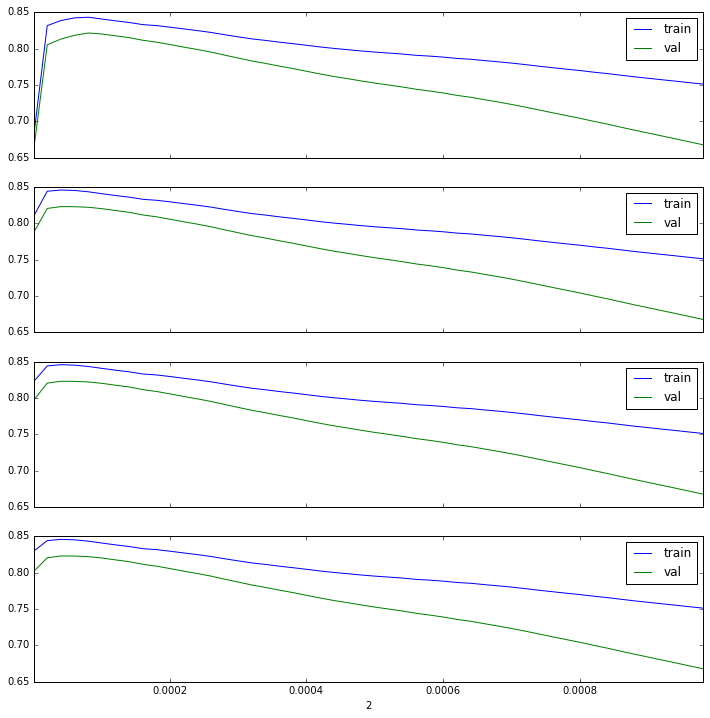

In [66]:
fig, axes = plt.subplots(4,1, figsize=(12,12), sharey='all', sharex='all')
for i, (name, g) in enumerate(r.groupby('C')):
    if name < 20:
        g[['train','val']].plot(ax=axes[i])

In [87]:
R = r.reset_index()

In [88]:
x = R['val'].argmax()

In [90]:
R.iloc[x,:]

2             4.1e-05
train        0.845695
val          0.822911
gamma    (4.1e-05, 6)
C                   6
Name: 21, dtype: object

In [59]:
results5 = {}
for  e in xrange(1,1020, 100):
    print e
    gamma = 0.00001*e
    results5[e] = evaluate(SVR(kernel='rbf', C=100, gamma=gamma),iterative=True, param = gamma)

1
101
201
301
401
501
601
701
801
901
1001


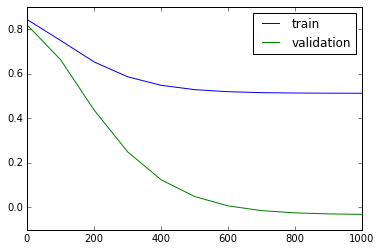

In [60]:
r2 = pd.DataFrame(results5).T
r2.columns = ('train','validation', 'param')
r2[['train', 'validation']].plot()


In [61]:
r2.max()

train         0.84165
validation    0.81749
param         0.01001
dtype: float64

## SVR poly

In [68]:
evaluate(SVR(kernel='poly', C=100, degree=3, gamma=0.05))

train: 0.699011719274
valid: 0.584728830126


In [70]:
resultsPoly = {}
for  e in xrange(1,1001, 100):
    for  c in xrange(1,101,5):
        print e, c
        gamma = 0.00001*e
        resultsPoly[(e,c)] = evaluate(SVR(kernel='rbf', C=c, gamma=gamma),iterative=True, param = (gamma,c))

1 1
1 6
1 11
1 16
1 21
1 26
1 31
1 36
1 41
1 46
1 51
1 56
1 61
1 66
1 71
1 76
1 81
1 86
1 91
1 96
101 1
101 6
101 11
101 16
101 21
101 26
101 31
101 36
101 41
101 46
101 51
101 56
101 61
101 66
101 71
101 76
101 81
101 86
101 91
101 96
201 1
201 6
201 11
201 16
201 21
201 26
201 31
201 36
201 41
201 46
201 51
201 56
201 61
201 66
201 71
201 76
201 81
201 86
201 91
201 96
301 1
301 6
301 11
301 16
301 21
301 26
301 31
301 36
301 41
301 46
301 51
301 56
301 61
301 66
301 71
301 76
301 81
301 86
301 91
301 96
401 1
401 6
401 11
401 16
401 21
401 26
401 31
401 36
401 41
401 46
401 51
401 56
401 61
401 66
401 71
401 76
401 81
401 86
401 91
401 96
501 1
501 6
501 11
501 16
501 21
501 26
501 31
501 36
501 41
501 46
501 51
501 56
501 61
501 66
501 71
501 76
501 81
501 86
501 91
501 96
601 1
601 6
601 11
601 16
601 21
601 26
601 31
601 36
601 41
601 46
601 51
601 56
601 61
601 66
601 71
601 76
601 81
601 86
601 91
601 96
701 1
701 6
701 11
701 16
701 21
701 26
701 31
701 36
701 41
701 46
701 51

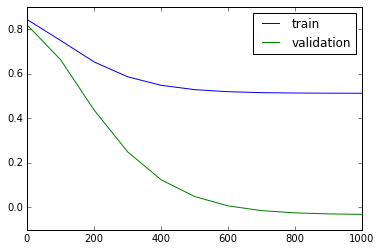

In [71]:
resultsPoly = pd.DataFrame(results5).T
resultsPoly.columns = ('train','validation', 'param')
resultsPoly[['train', 'validation']].plot()


In [72]:
resultsPoly.max()

train         0.84165
validation    0.81749
param         0.01001
dtype: float64

In [17]:
evaluate(SVR(kernel='linear', C=100, gamma=0.05))

train: 0.832542738931
valid: 0.808236460745


In [21]:
resultsLin = {}
for  e in xrange(1,1020, 20):
#     print e
    gamma = 0.00001*e
    resultsLin[e] = evaluate(SVR(kernel='linear', C=1000, gamma=gamma),iterative=True, param = gamma)

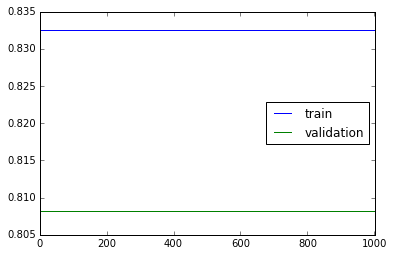

In [22]:
resultsLin = pd.DataFrame(resultsLin).T
resultsLin.columns = ('train','validation', 'param')
resultsLin[['train', 'validation']].plot()


In [23]:
resultsLin.max()

train         0.832543
validation    0.808236
param         0.010010
dtype: float64

### TESTING RBF KERNNEL

In [91]:
# using RBF tweaked hyperparameters
'''
2             4.1e-05
train        0.845695
val          0.822911
gamma    (4.1e-05, 6)
C                   6
'''
svr = SVR(kernel='rbf', C=6, gamma=4.1e-05)


In [93]:
svr.fit(datas['Xtrain'], datas['ytrain'])
svr.score(datas['Xtest'], datas['ytest'])

0.83174525142081124

Final prediction accuracy on train set is .831